# Tab Hero - Inference Demo

Load a trained model, run inference on a sample track, and visualise the output.
Produces three views: a waveform/spectrogram sanity-check, a piano-roll overview,
and a scrolling note highway (mp4 with audio, no ffmpeg needed).


In [1]:
import sys, os
sys.path.insert(0, os.path.join(os.path.dirname(os.getcwd()), "src"))

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.animation as animation
from pathlib import Path
from IPython.display import HTML, display

import torch
from tab_hero.inference import TabHeroPipeline, SongMetadata
from tab_hero.dataio import AudioProcessor

%matplotlib inline
plt.rcParams["figure.dpi"] = 100
print("Imports OK")


Imports OK


In [2]:
# edit paths and sampling parameters as needed
MODEL_PATH  = "../checkpoints/best_model.pt"
AUDIO_PATH  = "../data/sample/demo/funk_game_loop.mp3"
DATA_DIR    = "../data/sample/processed"

DIFFICULTY  = "expert"       # easy | medium | hard | expert
INSTRUMENT  = "bass"         # lead | bass | rhythm | keys
TEMPERATURE = 1.0            # lower = more deterministic; try 0.7–1.0
TOP_K       = 50             # keep top-K tokens per step (None to disable)
TOP_P       = 0.95           # nucleus sampling threshold (None to disable)
# Constrained decoding (vocab_ranges) is applied automatically by the generator
# - it enforces the T-F-M-D quad structure and eliminates wrong-position tokens.
SEED        = None           # integer for reproducibility; None for random

# Post-processing: discard notes within MIN_NOTE_GAP_MS of the previous one.
# Prevents physically impossible runs (>20 NPS) caused by degenerate time-delta
# token sequences.  50 ms = ~20 NPS maximum.  Set to 0 to disable.
MIN_NOTE_GAP_MS = 50

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device  : {DEVICE}")
print(f"Audio   : {AUDIO_PATH}")
print(f"Model   : {MODEL_PATH}")


Device  : cuda
Audio   : ../data/sample/demo/funk_game_loop.mp3
Model   : ../checkpoints/best_model.pt


In [3]:
pipeline = TabHeroPipeline(
    model_path=MODEL_PATH,
    device=DEVICE,
    data_dir=DATA_DIR,
)
n_params = sum(p.numel() for p in pipeline.generator.model.parameters())
print(f"Model loaded - {n_params:,} parameters")
m = pipeline.generator.model
print(f"Encoder dim: {m.encoder_dim}  |  Decoder dim: {m.decoder_dim}  |  Layers: {m.n_decoder_layers}")


Model loaded - 100,386,048 parameters
Encoder dim: 768  |  Decoder dim: 768  |  Layers: 8


## 1 - Audio Analysis

The waveform and log-mel spectrogram give a quick sanity-check that the audio
loaded correctly and show the frequency content the model will process.


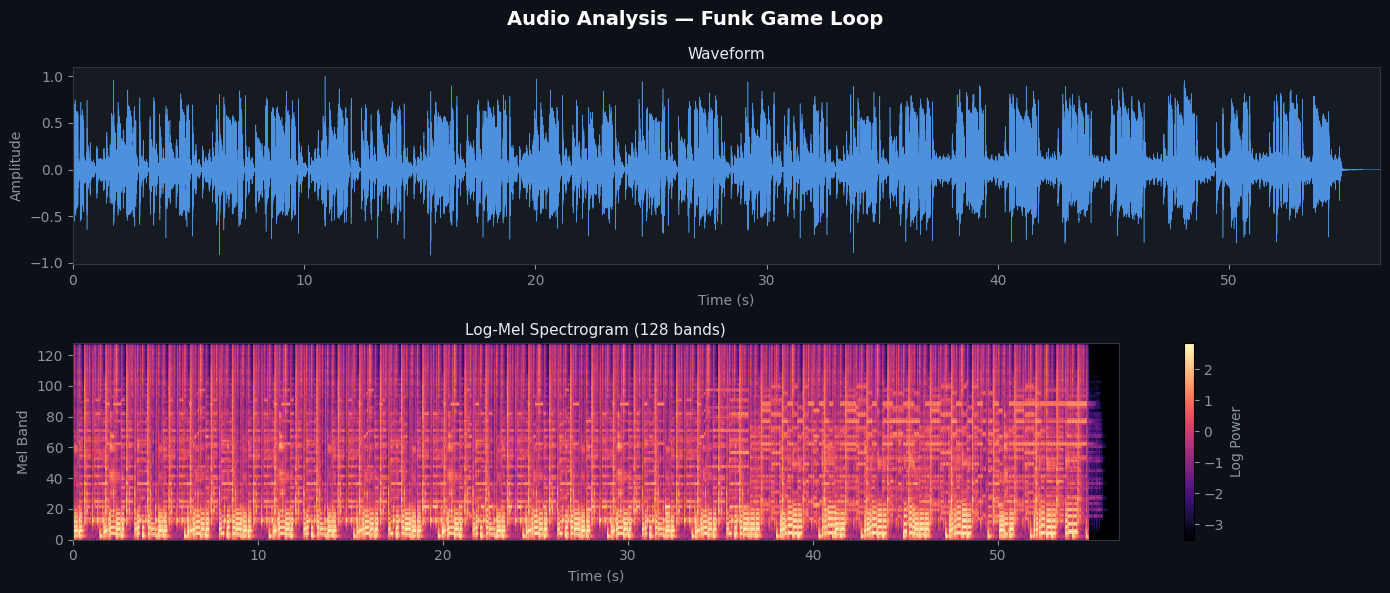

Duration: 56.53s  |  SR: 22050 Hz  |  Mel frames: 4870


In [4]:
processor    = AudioProcessor(device=DEVICE, data_dir=DATA_DIR)
waveform, sr = processor.load_audio(AUDIO_PATH)
waveform_np  = waveform.squeeze().cpu().numpy()
duration_sec = len(waveform_np) / sr

song_title = Path(AUDIO_PATH).stem.replace("_", " ").title()

fig, axes = plt.subplots(2, 1, figsize=(14, 6), facecolor="#0d1117")
fig.suptitle(f"Audio Analysis - {song_title}",
             color="white", fontsize=14, fontweight="bold")

# Waveform
ax1 = axes[0]
ax1.set_facecolor("#161b22")
times = np.linspace(0, duration_sec, len(waveform_np))
ax1.plot(times, waveform_np, color="#58a6ff", linewidth=0.4, alpha=0.85)
ax1.set_xlabel("Time (s)", color="#8b949e")
ax1.set_ylabel("Amplitude", color="#8b949e")
ax1.set_title("Waveform", color="#e6edf3", fontsize=11)
ax1.tick_params(colors="#8b949e")
ax1.set_xlim(0, duration_sec)
for s in ax1.spines.values():
    s.set_color("#30363d")

# Log-Mel spectrogram
ax2 = axes[1]
ax2.set_facecolor("#161b22")
mel, _ = processor.process_audio_file(AUDIO_PATH)
mel_np  = mel.cpu().numpy().T          # (n_mels, n_frames)
img = ax2.imshow(
    mel_np, aspect="auto", origin="lower",
    extent=[0, duration_sec, 0, 128],
    cmap="magma", interpolation="nearest",
)
ax2.set_xlabel("Time (s)", color="#8b949e")
ax2.set_ylabel("Mel Band", color="#8b949e")
ax2.set_title("Log-Mel Spectrogram (128 bands)", color="#e6edf3", fontsize=11)
ax2.tick_params(colors="#8b949e")
for s in ax2.spines.values():
    s.set_color("#30363d")
cb = plt.colorbar(img, ax=ax2, label="Log Power")
cb.ax.yaxis.label.set_color("#8b949e")
cb.ax.tick_params(colors="#8b949e")

plt.tight_layout()
plt.show()
print(f"Duration: {duration_sec:.2f}s  |  SR: {sr} Hz  |  Mel frames: {mel.shape[0]}")


## 2 - Run Inference

`ChartGenerator.generate()` encodes the audio into a log-mel spectrogram, then
autoregressively decodes note tokens using **constrained decoding** - at each step,
the logit mask restricts sampling to only the valid token type for that position
(TIME → FRET → MOD → DUR, repeating). This eliminates structural errors and
open-note spam without any retraining.

Each generated note has a `timestamp_ms`, a list of `frets` (0–4), and a
`duration_ms`. Notes beyond the audio boundary are clipped automatically.


In [5]:
print(f"Running {DIFFICULTY} {INSTRUMENT} inference on {Path(AUDIO_PATH).name} ...")
if SEED is not None:
    torch.manual_seed(SEED)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(SEED)

result = pipeline.generator.generate(
    audio_path=AUDIO_PATH,
    difficulty=DIFFICULTY,
    instrument=INSTRUMENT,
    temperature=TEMPERATURE,
    top_k=TOP_K,
    top_p=TOP_P,
)
all_notes = result["notes"]

# audio_duration_ms and note clipping are handled inside generator.generate().
audio_duration_ms = int(result["audio_duration_ms"])
notes  = list(all_notes)
clipped = 0

# 2. Filter notes closer than MIN_NOTE_GAP_MS to the previous note
if MIN_NOTE_GAP_MS > 0:
    filtered, prev_ts = [], -MIN_NOTE_GAP_MS
    for n in sorted(notes, key=lambda x: x["timestamp_ms"]):
        if n["timestamp_ms"] - prev_ts >= MIN_NOTE_GAP_MS:
            filtered.append(n)
            prev_ts = n["timestamp_ms"]
    gap_removed = len(notes) - len(filtered)
    notes = filtered
else:
    gap_removed = 0

print(f"\nGenerated      : {len(all_notes)} note events")
if clipped:
    print(f"Clipped (>song): {clipped} notes beyond {audio_duration_ms / 1000:.1f}s")
if gap_removed:
    print(f"Thinned (<gap) : {gap_removed} notes within {MIN_NOTE_GAP_MS}ms of previous")
print(f"Kept           : {len(notes)} notes")

if notes:
    ts_vals    = [n["timestamp_ms"] for n in notes]
    span_s     = (max(ts_vals) - min(ts_vals)) / 1000
    avg_nps    = len(notes) / span_s if span_s > 0 else 0
    open_notes = sum(1 for n in notes if len(n["frets"]) == 0)
    fretted    = len(notes) - open_notes
    chords     = sum(1 for n in notes if len(n["frets"]) > 1)
    fret_cnt   = {}
    for n in notes:
        for f in n["frets"]:
            fret_cnt[f] = fret_cnt.get(f, 0) + 1
    print(f"Chart span     : {span_s:.2f}s")
    print(f"Notes / second : {avg_nps:.2f}")
    print(f"Fretted        : {fretted} ({fretted / len(notes) * 100:.1f}%)")
    print(f"Open (no fret) : {open_notes} ({open_notes / len(notes) * 100:.1f}%)")
    print(f"Chords (2+)    : {chords} ({chords / len(notes) * 100:.1f}%)")
    print(f"Fret spread    : { {k: v for k, v in sorted(fret_cnt.items())} }")

# used by rendering cells
song_duration_ms = audio_duration_ms


Running expert bass inference on funk_game_loop.mp3 ...

Generated      : 170 note events
Kept           : 170 notes
Chart span     : 45.54s
Notes / second : 3.73
Fretted        : 170 (100.0%)
Open (no fret) : 0 (0.0%)
Chords (2+)    : 0 (0.0%)
Fret spread    : {0: 30, 1: 101, 2: 36, 3: 3}


## 3 - Piano-Roll

Each rectangle is a note event. Lanes (y-axis): fret 0 = Green · 1 = Red · 2 = Yellow · 3 = Blue · 4 = Orange.
Note width = duration; first 60 s shown.


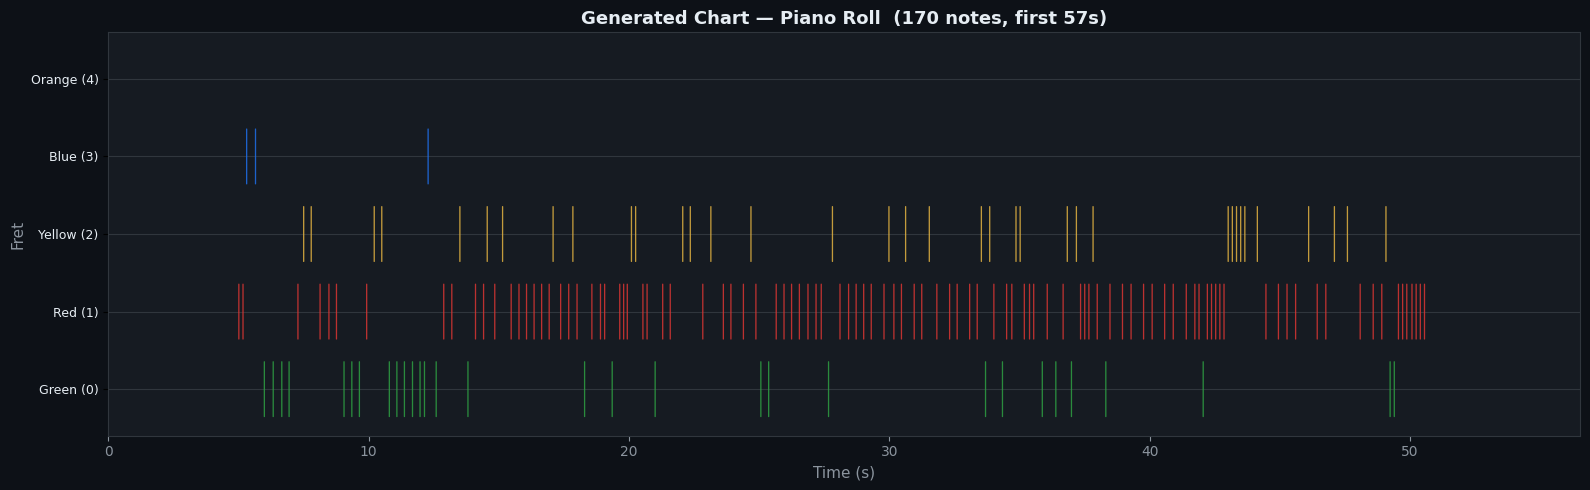

In [6]:
FRET_COLORS = ["#2ea043", "#da3633", "#e3b341", "#1f6feb", "#fd7e14"]
FRET_LABELS = ["Green (0)", "Red (1)", "Yellow (2)", "Blue (3)", "Orange (4)"]

display_end_s = min(song_duration_ms / 1000, 60)

fig, ax = plt.subplots(figsize=(16, 5), facecolor="#0d1117")
ax.set_facecolor("#161b22")

for note in notes:
    ts_s  = note["timestamp_ms"] / 1000
    dur_s = max(note.get("duration_ms", 30), 30) / 1000
    if ts_s > display_end_s:
        continue
    for fret in note["frets"]:
        if not 0 <= fret <= 4:
            continue
        rect = patches.FancyBboxPatch(
            (ts_s, fret - 0.35), dur_s, 0.70,
            boxstyle="round,pad=0.01",
            facecolor=FRET_COLORS[fret], edgecolor="none",
            alpha=0.85, zorder=3,
        )
        ax.add_patch(rect)

for f in range(5):
    ax.axhline(y=f, color="#30363d", linewidth=0.8, zorder=1)

ax.set_xlim(0, display_end_s)
ax.set_ylim(-0.6, 4.6)
ax.set_xlabel("Time (s)", color="#8b949e", fontsize=11)
ax.set_ylabel("Fret", color="#8b949e", fontsize=11)
ax.set_yticks(range(5))
ax.set_yticklabels(FRET_LABELS, color="#e6edf3", fontsize=9)
ax.tick_params(axis="x", colors="#8b949e")
ax.set_title(
    f"Generated Chart - Piano Roll  ({len(notes)} notes, first {display_end_s:.0f}s)",
    color="#e6edf3", fontsize=13, fontweight="bold",
)
for s in ax.spines.values():
    s.set_color("#30363d")
plt.tight_layout()
plt.show()
